In [1]:
import os, sys
# Reference: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.generated.generated_data import get_noisy_nonlinear_with_non_noisy_labels
import DimensionalityReduction.DimensionalityReductionDatasets as dr_datasets

import TrainingCurves

import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

GS_FILE_NAME_PREFIX = None

ALGO = "Neural Network"
DATASET = "Noisy Non-Linear"
GLOBAL_FIG_COUNTER = 0

default_title = "{} Default Learning Curve\n Data Set: {}".format(ALGO, DATASET)
final_title = "{} Final Tuning Learning Curve\n Data Set: {}".format(ALGO, DATASET)

ylim=(0.5, 1.0)

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
import NN_DimensionalityReduction.common_NN as common_NN
X_train, X_test, y_train, y_test, y_test_non_noisy = get_noisy_nonlinear_with_non_noisy_labels()
X_train,X_test = dr_datasets.get_gnnl_pca()
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

num_features = X_train.shape[1]

Running PCA for 5 components


In [4]:
# Start with Learning Curve on Default Classifier
default_train_sizes, default_train_scores, default_test_scores, default_fit_times, default_score_times\
= TrainingCurves.perform_learning_curve(MLPClassifier(), X_train, y_train, "accuracy")

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

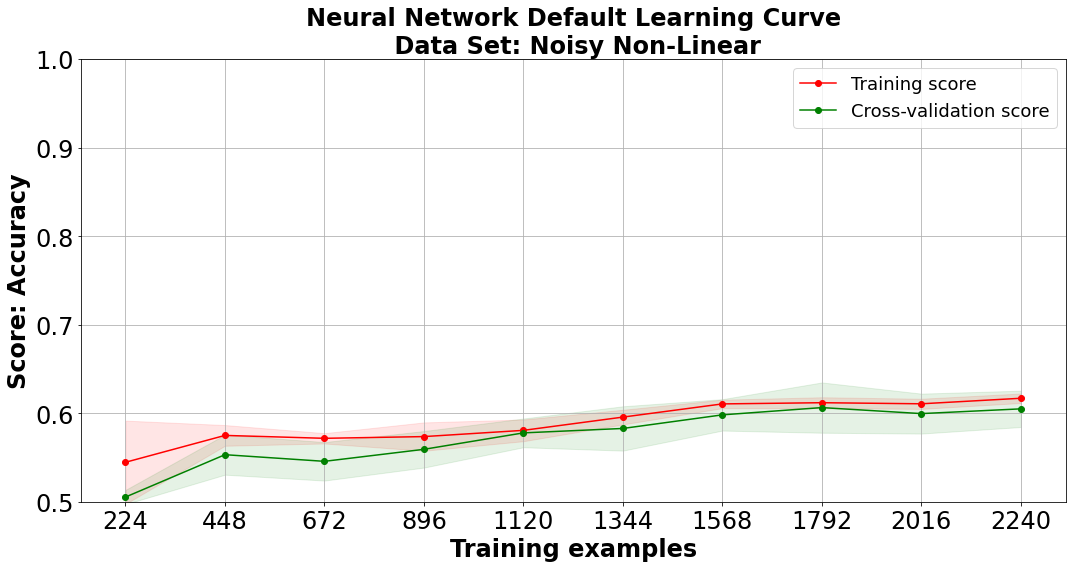

In [5]:
TrainingCurves.plot_learning_curve(default_train_scores, default_test_scores, default_train_sizes, default_title, ylim=ylim)

Running Epochs: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 27

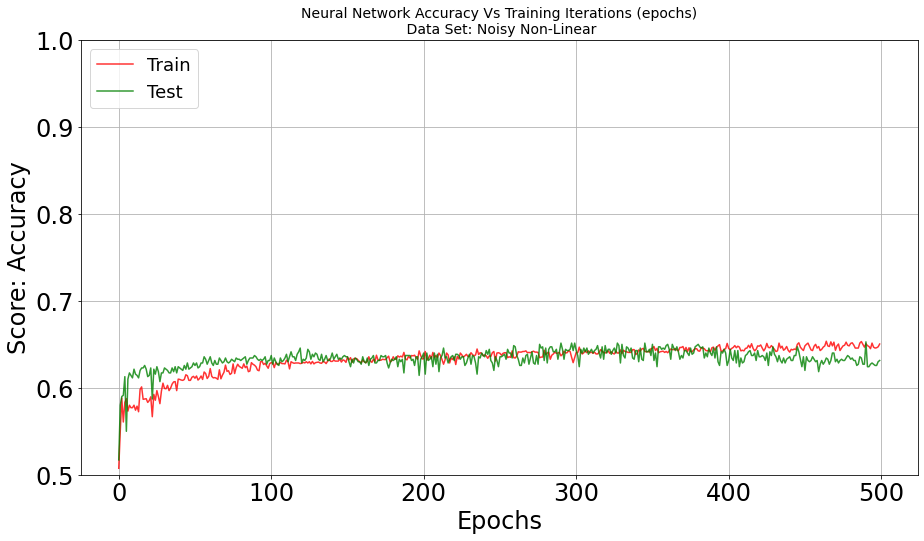

In [6]:
def loss_curve(X_train, y_train, mlp, N_EPOCHS=500, N_BATCH=64):
    # https://stackoverflow.com/questions/46912557/is-it-possible-to-get-test-scores-for-each-iteration-of-mlpclassifier
    N_TRAIN_SAMPLES = X_train.shape[0]
    N_CLASSES = np.unique(y_train)

    scores_train = []
    scores_test = []

    # EPOCH
    epoch = 0
    print("Running Epochs: ", end='')
    while epoch < N_EPOCHS:
        print(epoch, end=' ')
        # SHUFFLING
        random_perm = np.random.permutation(X_train.shape[0])
        mini_batch_index = 0
        while True:
            # MINI-BATCH
            indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
            t = X_train[indices]
            x = y_train[indices]
            mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
            mini_batch_index += N_BATCH

            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

        # SCORE TRAIN
        scores_train.append(mlp.score(X_train, y_train))

        # SCORE TEST
        scores_test.append(mlp.score(X_test, y_test))

        epoch += 1
    print()
    return scores_train, scores_test

def plot_loss_curve(scores_train, scores_test, ALGO, DATASET, ylim, legend_loc="upper left"):
    title_fontsize = 24
    fontsize = 24
    legend_fontsize = 18
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.rcParams["figure.figsize"] = (15,8)

    title = "{} Accuracy Vs Training Iterations (epochs)\n Data Set: {}".format(ALGO, DATASET)

    plt.plot(scores_train, color='red', alpha=0.8, label='Train')
    plt.plot(scores_test, color='green', alpha=0.8, label='Test')
    plt.title(title, fontsize=14)
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.ylabel("Score: Accuracy", fontsize=fontsize)
    plt.legend(loc=legend_loc, fontsize=legend_fontsize)
    plt.grid()
    plt.ylim(ylim)
    plt.show()


scores_train, scores_test = loss_curve(np.array(X_train), np.array(y_train), MLPClassifier(), N_BATCH=44)
plot_loss_curve(scores_train, scores_test, ALGO, DATASET, ylim=ylim)

In [ ]:
default_parameters = {"batch_size": 64, "max_iter": 400, 'learning_rate_init': 0.0045}

In [10]:
learning_rate_init=[i for i in np.arange(0.0005, 0.0355, 0.0005)]

train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = \
TrainingCurves.perform_validation_curve(MLPClassifier(**default_parameters), X_train, y_train, "learning_rate_init", learning_rate_init, 'accuracy', cv=TrainingCurves.get_cv(), verbose=10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 out of 700 | elapsed:   20.1s remaining:  3.4min
[Parallel(n_jobs=-1)]: Done 133 out of 700 | elapsed:   39.7s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done 204 out of 700 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done 275 out of 700 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done 346 out of 700 | elapsed:  1.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done 417 out of 700 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 488 out of 700 | elapsed:  2.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 559 out of 700 | elapsed:  2.7min remaining:   41.0s
[Parallel(n_jobs=-1)]: Done 630 out of 700 | elapsed:  3.1min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  3.4min finished


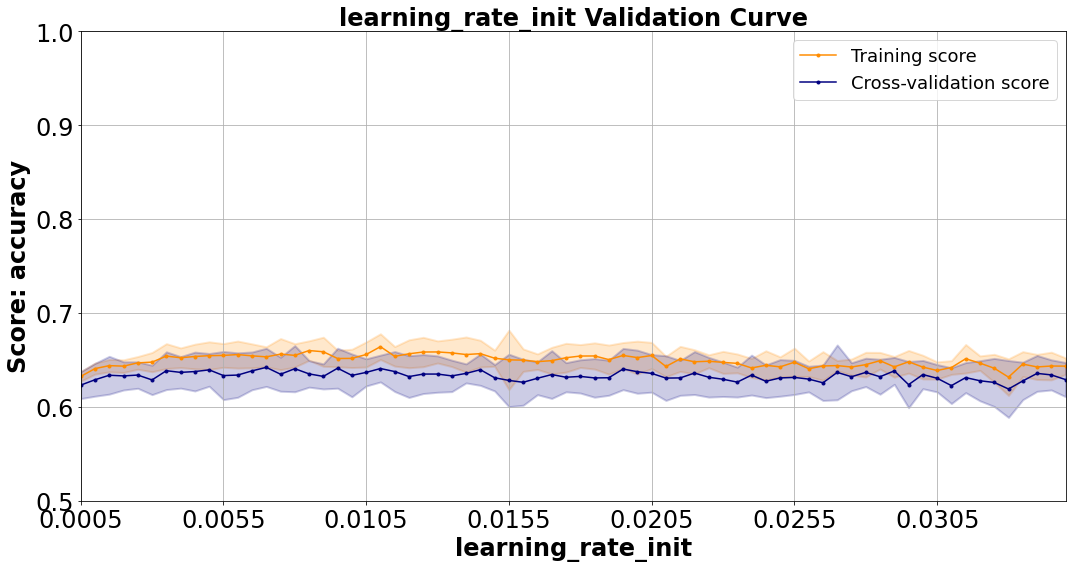

In [11]:
TrainingCurves.plot_validation_curve(train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, "learning_rate_init", learning_rate_init, title="learning_rate_init Validation Curve", scoring="accuracy", tick_spacing=10, ylim=ylim)


In [15]:
default_parameters = {"batch_size": 64, "max_iter": 400, 'learning_rate_init': 0.0045}

In [16]:
import pickle

num_nodes_per_layer = [i for i in range(10, 150, 10)]
num_hidden_layers = [i for i in range(1, 4, 1)]

hidden_layer_sizes = []
for num_layers in num_hidden_layers:
    for num_nodes in num_nodes_per_layer:
        tmp_hl = []
        for i in range(num_layers):
            tmp_hl.append(num_nodes)
        hidden_layer_sizes.append(tmp_hl)


hidden_layer_sizes
string_hidden_layer_size = []
for i in hidden_layer_sizes:
    temp = ""
    for ii in i:
        temp += (str(ii) + " ,")
    temp=temp[:-2]
    string_hidden_layer_size.append(temp)

temp_file_name = 'temp_NN_val_score_NNL_GS_hidden_layer_range.pickle'

if(os.path.isfile(temp_file_name)):
    print("Warning not running using: ", temp_file_name)
    with open(temp_file_name, 'rb') as handle:
        train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = pickle.load(handle)
else:
    train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = TrainingCurves.perform_validation_curve(MLPClassifier(**default_parameters), X_train, y_train, 'hidden_layer_sizes', hidden_layer_sizes, 'accuracy', cv=TrainingCurves.get_cv(), n_jobs=-1, verbose=10)
    with open(temp_file_name, 'wb') as handle:
        pickle.dump((train_scores_mean, train_scores_std, test_scores_mean, test_scores_std), handle, protocol=pickle.HIGHEST_PROTOCOL)


Warning not running using:  temp_NN_val_score_NNL_GS_hidden_layer_range.pickle


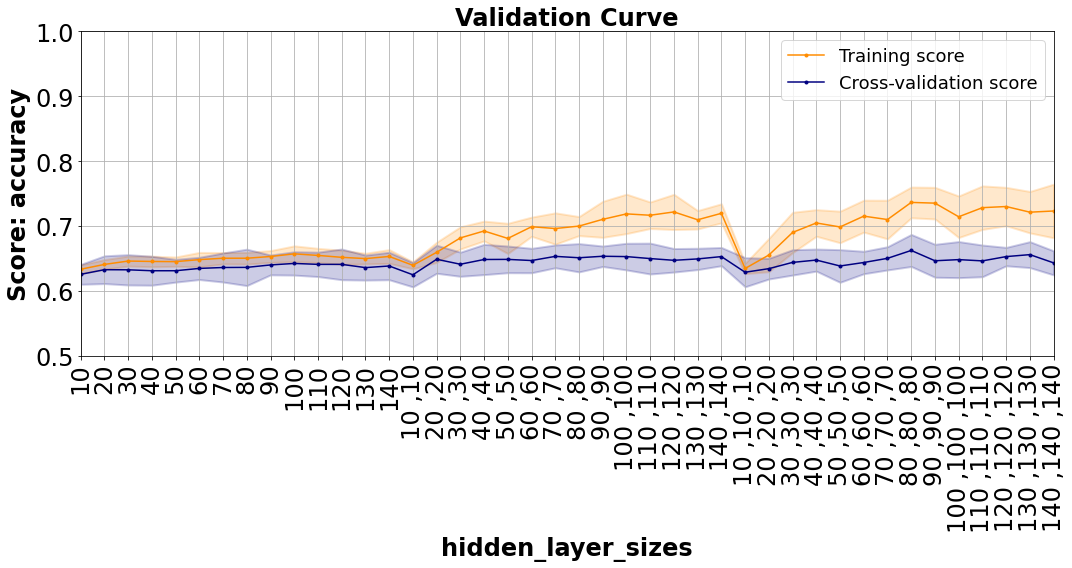

In [17]:
TrainingCurves.plot_validation_curve(train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, "hidden_layer_sizes", string_hidden_layer_size, title="Validation Curve", scoring="accuracy", tick_spacing=1, rotation='vertical', ylim=ylim)

In [19]:
final_parameters = {'batch_size': 64, 'learning_rate_init': 0.0045, 'hidden_layer_sizes': [20, 20]}

In [20]:
# Final Learning Curve
train_sizes, train_scores, test_scores, fit_times, score_times\
= TrainingCurves.perform_learning_curve(MLPClassifier(**final_parameters), X_train, y_train, "accuracy")

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

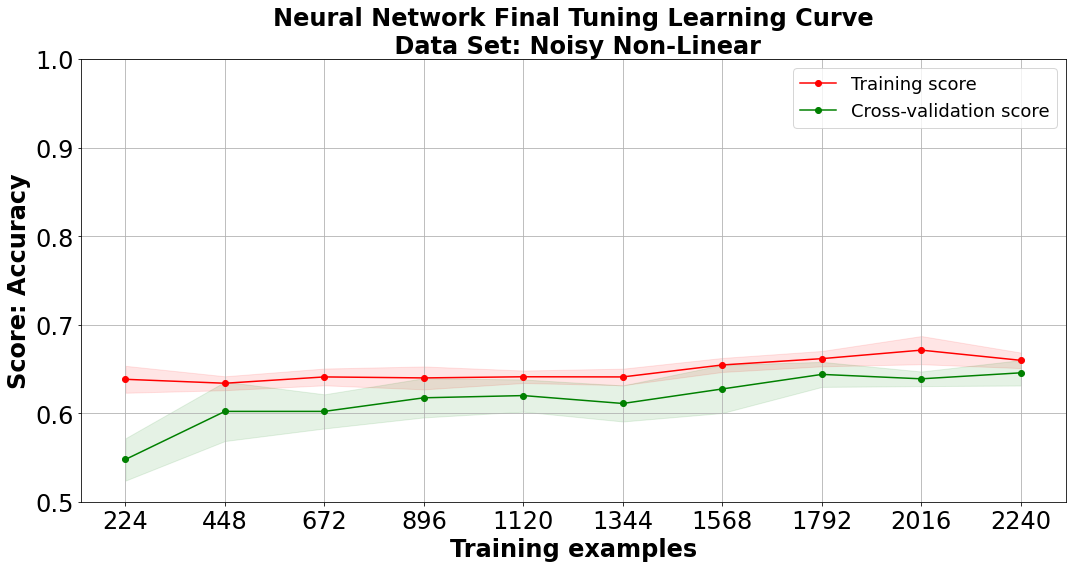

In [21]:
TrainingCurves.plot_learning_curve(train_scores, test_scores, train_sizes, final_title, ylim=ylim)

In [22]:
scores_train, scores_test = loss_curve(np.array(X_train), np.array(y_train), MLPClassifier(**final_parameters))

Running Epochs: 0 1 2 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


3 4 5 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


6 7 8 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


9 10 11 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


12 13 14 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


15 16 17 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


18 19 20 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


21 22 23 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


24 25 26 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


27 28 29 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


30 31 32 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


33 34 35 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


36 37 38 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


39 40 41 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


42 43 44 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


45 46 47 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


48 49 50 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


51 52 53 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


54 55 56 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


57 58 59 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


60 61 62 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


63 64 65 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


66 67 68 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


69 70 71 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


72 73 74 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


75 76 77 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


78 79 80 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


81 82 83 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


84 85 86 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


87 88 89 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


90 91 92 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


93 94 95 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


96 97 98 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


99 100 101 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


102 103 104 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


105 106 107 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


108 109 110 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


111 112 113 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


114 115 116 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


117 118 119 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


120 121 122 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


123 124 125 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


126 127 128 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


129 130 131 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


132 133 134 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


135 136 137 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


138 139 140 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


141 142 143 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


144 145 146 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


147 148 149 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


150 151 152 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


153 154 155 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


156 157 158 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


159 160 161 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


162 163 164 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


165 166 167 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


168 169 170 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


171 172 173 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


174 175 176 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


177 178 179 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


180 181 182 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


183 184 185 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


186 187 188 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


189 190 191 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


192 193 194 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


195 196 197 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


198 199 200 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


201 202 203 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


204 205 206 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


207 208 209 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


210 211 212 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


213 214 215 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


216 217 218 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


219 220 221 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


222 223 224 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


225 226 227 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


228 229 230 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


231 232 233 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


234 235 236 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


237 238 239 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


240 241 242 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


243 244 245 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


246 247 248 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


249 250 251 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


252 253 254 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


255 256 257 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


258 259 260 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


261 262 263 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


264 265 266 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


267 268 269 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


270 271 272 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


273 274 275 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


276 277 278 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


279 280 281 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


282 283 284 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


285 286 287 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


288 289 290 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


291 292 293 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


294 295 296 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


297 298 299 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


300 301 302 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


303 304 305 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


306 307 308 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


309 310 311 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


312 313 314 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


315 316 317 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


318 319 320 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


321 322 323 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


324 325 326 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


327 328 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


329 330 331 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


332 333 334 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


335 336 337 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


338 339 340 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


341 342 343 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


344 345 346 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


347 348 349 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


350 351 352 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


353 354 355 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


356 357 358 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


359 360 361 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


362 363 364 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


365 366 367 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


368 369 370 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


371 372 373 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


374 375 376 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


377 378 379 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


380 381 382 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


383 384 385 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


386 387 388 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


389 390 391 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


392 393 394 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


395 396 397 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


398 399 400 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


401 402 403 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


404 405 406 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


407 408 409 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


410 411 412 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


413 414 415 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


416 417 418 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


419 420 421 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


422 423 424 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


425 426 427 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


428 429 430 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


431 432 433 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


434 435 436 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


437 438 439 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


440 441 442 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


443 444 445 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


446 447 448 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


449 450 451 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


452 453 454 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


455 456 457 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


458 459 460 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


461 462 463 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


464 465 466 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


467 468 469 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


470 471 472 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


473 474 475 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


476 477 478 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


479 480 481 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


482 483 484 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


485 486 487 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


488 489 490 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


491 492 493 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


494 495 496 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


497 498 499 

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:353: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


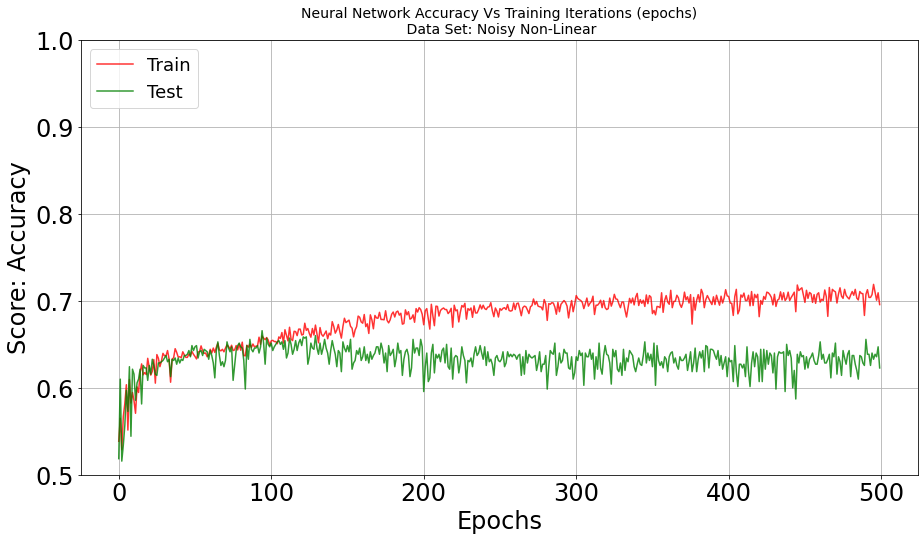

In [23]:
plot_loss_curve(scores_train, scores_test, ALGO, DATASET, ylim=ylim)

In [24]:
print("Default Fit Time: {} seconds".format(round(np.mean(default_fit_times, axis=1)[-1], 3)))
print("Default Predict Time {} seconds".format(round(np.mean(default_score_times, axis=1)[-1], 3)))
print()
print("Final Fit Time: {} seconds".format(round(np.mean(fit_times, axis=1)[-1], 3)))
print("Final Predict Time: {} seconds".format(round(np.mean(score_times, axis=1)[-1], 3)))


Default Fit Time: 2.756 seconds
Default Predict Time 0.003 seconds

Final Fit Time: 2.249 seconds
Final Predict Time: 0.002 seconds


In [25]:
clf = MLPClassifier(**final_parameters)
clf.fit(X_train, y_train)
print("Train Accuracy: {}%".format(round(clf.score(X_train, y_train)*100, 1)))
print("Test Accuracy: {}%".format(round(clf.score(X_test, y_test)*100, 1)))


Train Accuracy: 64.9%
Test Accuracy: 65.1%


In [26]:
print("Correct Non Noisy Test Accuracy {}%".format(round(clf.score(X_test, y_test_non_noisy)*100, 1)))

Correct Non Noisy Test Accuracy 73.7%
